In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch
from torch import nn
from torch.nn import  init
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F 
import os

### 读取图片文件

In [3]:
def getFileList(dir, FileList,ext=None):
    """
    获取文件夹及子文件夹中的文件列表
    dir: 文件夹跟目录
    ext:扩展名
    返回:文件路径列表
    """
    newDir=dir
    if os.path.isfile(dir):  # os.path.isfile(dir)判断某一对象(需提供绝对路径)是否为文件
        if ext is None:
            FileList.append(dir) # 将文件添加到FileList中
        else:
            if ext in dir[-3:]:
                FileList.append(dir)  # 去掉拓展名之后在添加到FileList中
    elif os.path.isdir(dir): # os.path.isdir()：判断某一对象(需提供绝对路径)是否为目录
        for s in os.listdir(dir):  # os.listdir()：返回一个列表，其中包含有指定路径下的目录和文件的名称
            """
            有时系统中会出现一个desktop.ini的隐藏文件会被读入
            """
            if s[-3:]=="jpg":
                newDir=os.path.join(dir,s)  # 拼接路径
                getFileList(newDir,FileList,ext)
        return FileList

In [4]:
# 检索文件
org_img_folder=r"D:\jupyter-notebook\8-15 实验3\dataset"  # bus car truck

total_imglist=[]
for folder in os.listdir(org_img_folder):
    new_org=os.path.join(org_img_folder,folder)
    imgList = getFileList(new_org,[])
    total_imglist.append(imgList)
    print('本次执行检索到 '+ folder +" "+str(len(imgList))+' 张图像\n')

本次执行检索到 bus 218 张图像

本次执行检索到 car 779 张图像

本次执行检索到 truck 360 张图像



In [5]:
bus_imglist=total_imglist[0]
car_imglist=total_imglist[1]
truck_imglist=total_imglist[2]

def tensor_list(imglist):
    count=0
    for array_img in imglist:
        img=Image.open(array_img)
        img=img.resize((64,64),Image.ANTIALIAS)
        img=np.array(img)
        img=np.expand_dims(img,0) # 从 100*100*3 变成 1*100*100*3
        # 归一化
        img=img/255 
        #1*H*W*C    1*C*H*W   0 1 2 3 ==> 0 3  1 2  X轴用0表示，Y轴用1表示；Z轴用2来表示；
        tensor_img=torch.tensor(np.transpose(img,(0,3,1,2)))
        if count==0:
            imglist=tensor_img
        else:
            imglist=torch.cat((imglist,tensor_img),0)
        count+=1
    return imglist

### 划分数据集

In [6]:
###训练集
bus_tensor=tensor_list(bus_imglist)
train_bus_tensor=bus_tensor[:int(bus_tensor.shape[0]*0.7)]


car_tensor=tensor_list(car_imglist)
train_car_tensor=car_tensor[:int(car_tensor.shape[0]*0.7)]

truck_tensor=tensor_list(truck_imglist)
train_truck_tensor=truck_tensor[:int(truck_tensor.shape[0]*0.7)]

print(train_bus_tensor.shape) # 152 3 100 100
print(train_car_tensor.shape) # 545 3 100 100
print(train_truck_tensor.shape) # 251

train_total_tensor=torch.cat((train_bus_tensor,train_car_tensor,train_truck_tensor),0)
print(train_total_tensor.shape)

torch.Size([152, 3, 64, 64])
torch.Size([545, 3, 64, 64])
torch.Size([251, 3, 64, 64])
torch.Size([948, 3, 64, 64])


In [7]:
# 测试集
test_bus_tensor=bus_tensor[int(bus_tensor.shape[0]*0.7):]
test_car_tensor=car_tensor[int(car_tensor.shape[0]*0.7):]
test_truck_tensor=truck_tensor[int(truck_tensor.shape[0]*0.7):]
test_total_tensor=torch.cat((test_bus_tensor,test_car_tensor,test_truck_tensor),0)
print(test_total_tensor.shape)

torch.Size([409, 3, 64, 64])


### 给类别分组 0 1 2

In [8]:
train_bus_labels=torch.zeros(train_bus_tensor.shape[0])  # bus 归为0类
train_car_labels=torch.ones(train_car_tensor.shape[0])   # car 归为1类
train_truck_labels=torch.ones(train_truck_tensor.shape[0])+1   # truck 归为2类

train_total_labels=torch.cat((train_bus_labels,train_car_labels,train_truck_labels),0)
print(train_total_labels.shape)


test_bus_labels=torch.zeros(test_bus_tensor.shape[0])  # bus 归为0类
test_car_labels=torch.ones(test_car_tensor.shape[0])   # car 归为1类
test_truck_labels=torch.ones(test_truck_tensor.shape[0])+1   # truck 归为2类

test_total_labels=torch.cat((test_bus_labels,test_car_labels,test_truck_labels),0)
print(test_total_labels.shape)

torch.Size([948])
torch.Size([409])


### 读取数据集

In [9]:
import torch.utils.data as Data

num_classes=3  # 3类
epochs=30

lr=0.01
batch_size=30
device=torch.device("cuda:0") # 使用device

# 将训练数据的特征和标签组合
train_dataset = Data.TensorDataset(train_total_tensor, train_total_labels)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(
    dataset=train_dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据，注意在Windows下需要设置为0
)

# 将训练数据的特征和标签组合
test_dataset = Data.TensorDataset(test_total_tensor, test_total_labels)
# 把 dataset 放入 DataLoader
test_iter = Data.DataLoader(
    dataset=test_dataset, # torch TensorDataset format
    batch_size=batch_size, # mini batch size
    shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
    num_workers=0, # 多线程来读数据，注意在Windows下需要设置为0
)

### pytorch 实现残差

### 残差块

In [10]:
#默认3*3卷积下padding为1，则大小不会变化，如变化则是步长引起的。
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size, stride=1, shortcut=True):
        super(ResidualBlock, self).__init__()
        #两层卷积层
        #不同步长只有第一层卷积层不同
        self.block1 = nn.Sequential(nn.Conv2d(in_channels , out_channels, size, stride, padding=1),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(out_channels, out_channels, size, 1, padding=1),
                                    nn.BatchNorm2d(out_channels))
        self.shortcut = shortcut
        #解决通道数变化以及步长不为1引起的图片大小的变化
        self.block2 = nn.Sequential(nn.Conv2d(in_channels , out_channels, size, stride, 1),
                                    nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU(inplace=True)
    def forward(self, input):
        x = input
        out = self.block1(x)
        '''若输入输出维度相等直接相加，不相等改变输入的维度--包括大小和通道'''
        if self.shortcut:
            out = x + out
        else:
            out = out + self.block2(x)
        out = self.relu(out)
        return out

### 残差网络

In [11]:
#定义给定的残差结构
class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #(H-K+2*P)/S + 1
        #t表示2个相同的残差块,每个残差块两个卷积
        self.d1 = self.make_layer(64, 64, 3, stride=1, t=2)
        self.d2 = self.make_layer(64, 128, 3, stride=2, t=2)
        self.d3 = self.make_layer(128, 256, 3, stride=2, t=2)
        self.d4 = self.make_layer(256, 512, 3, stride=2, t=2)

        self.avgp = nn.AvgPool2d(8)
        self.fc = nn.Linear(512, 3)

    def make_layer(self, in_channels, out_channels, ksize, stride, t):
        layers = []
        for i in range(0, t):
            if i == 0 and in_channels !=out_channels:
                layers.append(ResidualBlock(in_channels, out_channels, ksize, stride, None))
            else:
                layers.append(ResidualBlock(out_channels, out_channels, ksize, 1, True))
        return nn.Sequential(*layers)

    def forward(self, input):
        #(H-K+2*P)/S+1
        #(64-3+2*1)/1+1=64 输出64*64*64
        x = self.block(input)  # 输出维度 64 * 64 * 64    C * H * W
        #输入64进d1
        #makelayer k=3 s=1 t=2  in=64 out=64 相等 始终走else 传参true 只走block1
        #开始for循环
        #residual始终走else k=3 s=1 true
        #(64-3+2*1)/1+1=64 执行4次为64
        x = self.d1(x)  # 输出维度 64 * 64 * 64
        
        #输入64进d2 makelayer in=64 out=128 k=3 s=2 t=2 in和out不相等 分i=0和i=1两条路
        #for i =0 执行if  residualblock传参64  128  k=3  s=2  shortout为None
        #首先执行block1 两次卷积  第一次  k=3  s=2  p=1 第二次 k=3 s=1 p=1
        #(64-3+2*1)/2+1=32.5=32   (32-3+2*1)/1+1=32
        #由于shortout为none 所以还需要执行block2卷积k=3 s=2 p=1
        #(64-3+2*1)/2+1=32 然后返回32维+32维 还是32维
        
        #for i=1  执行else  k=3 s=1 shortout为True
        #执行block1  两次卷积 第一次 k=3 s=1 p=1  第二次 k=3  s=1 p=1
        #(32-3+2*1)/1+1=32 两次执行 还是32
        x = self.d2(x)  # i=0 步长为2，输出维度128 * 32 * 32
        x = self.d3(x)  # i=0 步长为2，输出维度256 * 16 * 16 
        x = self.d4(x)  # i=0 步长为2，输出维度512 * 8 * 8
        x = self.avgp(x)  # 512 * 1 * 1
        #将张量out从shape batchx512x1x1 变为 batch x512
        x = x.squeeze()
        output = self.fc(x)
        return output

### 初始化+损失函数+优化器

In [13]:
## 模型定义
net=resnet().to(device)
## loss函数
criterion=nn.CrossEntropyLoss()
## 使用Adam优化器
optimizer=torch.optim.Adam(net.parameters(),lr=lr)

### 测试训练函数

In [14]:
def train_epoch(net,data_loader,device):
    net.train()  ## 当前模式为训练模式
    train_batch_num=len(data_loader)  # 记录有多少个batch
    total_loss=0 # 记录loss
    correct=0    # 记录共有多个个样本被正确分类
    sample_num=0  # 记录样本总数
    
    ### 遍历每一个batch进行训练
    for batch_idx,(data,target)  in enumerate(data_loader):
        # 将图片放入指定的device中
        data=data.to(device).float()
        # 将图片标签放入指定的device中
        target=target.to(device).long()
        #将当前梯度清0
        optimizer.zero_grad()
        # 使用模型计算结果
        output=net(data)
        # 计算损失
        loss=criterion(output,target)
        # 进行反向传播
        loss.backward()
        optimizer.step()
        #累加Loss
        total_loss+=loss.item()
        # 找出每个样本最大的idx，即代表类别
        prediction=torch.argmax(output,1)
        # 统计正确的类别数量
        correct+=(prediction==target).sum().item()
        # 累加当前样本总数
        sample_num+=len(prediction)
    # 计算平均的loss与准确率
    loss=total_loss/train_batch_num
    acc=correct/sample_num
    return loss,acc

### 测试函数

In [15]:
def test_epoch(net,data_loader,device):
    net.eval()  ## 当前模式为训练模式
    test_batch_num=len(data_loader)  # 记录有多少个batch
    total_loss=0 # 记录loss
    correct=0    # 记录共有多个个样本被正确分类
    sample_num=0  # 记录样本总数
    
    
    with torch.no_grad():
        ### 遍历每一个batch进行训练
        for batch_idx,(data,target)  in enumerate(data_loader):
            # 将图片放入指定的device中
            data=data.to(device).float()
            # 将图片标签放入指定的device中
            target=target.to(device).long()
            
            output=net(data)
            # 计算损失
            loss=criterion(output,target)
        
            #累加Loss
            total_loss+=loss.item()
            # 找出每个样本最大的idx，即代表类别
            prediction=torch.argmax(output,1)
            # 统计正确的类别数量
            correct+=(prediction==target).sum().item()
            # 累加当前样本总数
            sample_num+=len(prediction)
    # 计算平均的loss与准确率
    loss=total_loss/test_batch_num
    acc=correct/sample_num
    return loss,acc

### 开始训练

In [16]:
train_loss_list=[]
train_acc_list=[]
test_loss_list=[]
test_acc_list=[]

# 进行训练
for epoch in range(epochs):
    # 在训练集上训练
    train_loss,train_acc=train_epoch(net,train_iter,device=device)
    # 在测试集上验证
    test_loss,test_acc=test_epoch(net,test_iter,device=device)
    
    ## 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
   
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    
    print(f"epoch:{epoch}  train_loss:{train_loss:.4f}  "
          f"train_acc:{train_acc}  "
          f"test_loss:{test_loss:.4f}  test_acc:{test_acc}")

epoch:0  train_loss:0.9407  train_acc:0.740506329113924  test_loss:7.7793  test_acc:0.29095354523227385
epoch:1  train_loss:0.4042  train_acc:0.8744725738396625  test_loss:2.1335  test_acc:0.4767726161369193
epoch:2  train_loss:0.3670  train_acc:0.8829113924050633  test_loss:3.9585  test_acc:0.4352078239608802
epoch:3  train_loss:0.3574  train_acc:0.8786919831223629  test_loss:2.2192  test_acc:0.5281173594132029
epoch:4  train_loss:0.2489  train_acc:0.9103375527426161  test_loss:4.3303  test_acc:0.4547677261613692
epoch:5  train_loss:0.2271  train_acc:0.9135021097046413  test_loss:3.1918  test_acc:0.3374083129584352
epoch:6  train_loss:0.2101  train_acc:0.9166666666666666  test_loss:3.0218  test_acc:0.4352078239608802
epoch:7  train_loss:0.2472  train_acc:0.9040084388185654  test_loss:1.1389  test_acc:0.6503667481662592
epoch:8  train_loss:0.2346  train_acc:0.9156118143459916  test_loss:2.6467  test_acc:0.4474327628361858
epoch:9  train_loss:0.1965  train_acc:0.9261603375527426  test_l

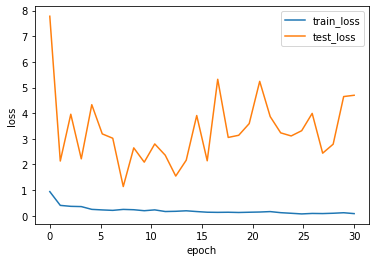

In [19]:
x = np.linspace(0,len(train_loss_list),len(train_loss_list))
plt.plot(x,train_loss_list,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss_list,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("new_loss.jpg")
plt.show()

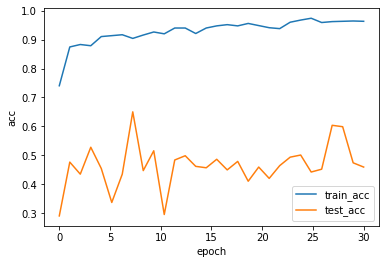

In [20]:
x = np.linspace(0,len(train_acc_list),len(train_acc_list))
plt.plot(x,train_acc_list,label="train_acc",linewidth=1.5)
plt.plot(x,test_acc_list,label="test_acc",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.savefig("new_acc.jpg")
plt.show()